In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from utils import *

In [2]:
# Set display format for floats to regular decimal notation
pd.set_option('display.float_format', '{:.20f}'.format)

In [3]:
tickers = [
    "AAPL", "MSFT", "GOOG", "AMZN", "NVDA", "ADBE", "ORCL", "CRM", "INTC", "CSCO",  # Technology
    "JNJ", "PFE", "MRK", "UNH", "BMY", "LLY", "ABBV", "GILD", "MDT", "ELV",         # Healthcare
    "PG", "KO", "PEP", "WMT", "CL", "KMB", "MO", "MDLZ", "GIS", "COST",             # Consumer Staples
    "TSLA", "NKE", "MCD", "SBUX", "TGT", "HD", "LOW", "TJX", "ROST", "AMT",         # Consumer Discretionary
    "JPM", "BAC", "GS", "WFC", "C", "AXP", "SCHW", "MS", "BLK", "USB",              # Financials
    "BA", "CAT", "MMM", "HON", "UNP", "LMT", "GE", "RTX", "UPS", "DE",              # Industrials
    "NEE", "DUK", "SO", "AEP", "EXC", "D", "XEL", "ED", "SRE", "PPL",               # Utilities
    "VZ", "T", "CMCSA", "DIS", "NFLX", "GOOGL", "META", "CHTR", "TMUS", "SPOT",     # Communication Services
    "XOM", "CVX", "COP", "SLB", "PSX", "VLO", "MPC", "HAL", "BKR", "OXY",           # Energy
    "IEF", "TLT", "GOVT", "BND", "LQD", "HYG", "TIP", "AGG", "VCIT", "VCSH",        # Bonds
    "VNQ", "IYR", "SCHH", "RWR", "XLRE", "PLD", "O", "SPG", "AVB", "EQR",           # REITs
    "GLD", "IAU", "SLV", "PDBC", "DBC", "USO", "UNG", "BNO", "GSG", "CORN"          # Commodities
]

# Download historical data for all tickers
data = yf.download(tickers, start="2005-01-01", end="2024-10-01")['Adj Close']

# Display the first few rows
# print(data.head())

[*********************100%%**********************]  120 of 120 completed


## Calculating Metrics

In [4]:
target_risk = 0.08

In [5]:
daily_returns = daily_returns_calc(data)
expected_daily_metrics = expected_daily_metric_calc(daily_returns)
expected_daily_returns = expected_daily_metrics['daily_returns']
daily_covariance_matrix = expected_daily_metrics['daily_covariance']
annual_metrics = annual_metrics_calc(expected_daily_returns, daily_covariance_matrix)
annual_returns = annual_metrics['annual_returns']
annual_covariance = annual_metrics['cov_matrix']

/Users/meganng/Desktop/DSA4212/Assignment/final/utils.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_returns = adj_close.ffill().pct_change().dropna()


## Running Optimisation on Unperturbed Data

In [6]:
# Running optimisation with target risk as 0.05
res = optimise_weights(annual_returns, annual_covariance, target_risk)
original_weights = res[0]

## Stability with Random Perturbations 

In [7]:
# Generate 20 values between 0.001 and 0.02
perturbations = np.linspace(0.0001, 0.02, 50)

# Lists to store final results
tot_mean = []
tot_max = []
tot_std = []
optimal_returns = []
optimal_risks = []

for perturbation in perturbations:
    # List to store differences in weights for each run
    weight_differences = []
    portfolio_returns = []
    portfolio_risks = []
    
    feasible_solution = True  # Flag to check if any solution is feasible

    for i in range(5):
        # Add random perturbation to the returns data
        perturbed_returns = daily_returns + np.random.normal(0, perturbation, daily_returns.shape)

        # Calculate covariance matrix and expected returns from perturbed data
        perturbed_cov_matrix = perturbed_returns.cov() * 252  # Annualized covariance matrix
        perturbed_expected_returns = perturbed_returns.mean() * 252  # Annualized expected returns

        # Define portfolio weights
        n_assets = len(perturbed_expected_returns)
        weights = cp.Variable(n_assets)

        # Define portfolio return and risk (variance)
        portfolio_return = perturbed_expected_returns.values @ weights
        portfolio_risk = cp.quad_form(weights, cp.psd_wrap(perturbed_cov_matrix))

        # Optimize to maximize return for a given risk
        target_risk = 0.08
        problem = cp.Problem(cp.Maximize(portfolio_return), [
            cp.sum(weights) == 1,
            weights >= 0,
            portfolio_risk <= target_risk**2
        ])
        
        problem.solve()

        # Check if the solution is feasible
        if problem.status != cp.OPTIMAL:
            feasible_solution = False
            break  # Stop further iterations if no feasible solution is found

        # Collect weights and portfolio metrics if feasible
        perturbed_weights = np.round(weights.value, 4)
        weight_diff = np.abs(original_weights - perturbed_weights)
        weight_differences.append(weight_diff)

        portfolio_returns.append(portfolio_return.value)
        portfolio_risks.append(portfolio_risk.value)

    if feasible_solution:
        # Calculate mean, max, std change in weights if solution was feasible
        diff_df = pd.DataFrame(weight_differences)
        tot_mean.append(diff_df.mean().mean())
        tot_max.append(diff_df.max().mean())
        tot_std.append(diff_df.std().mean())
        optimal_returns.append(sum(portfolio_returns) / len(portfolio_returns))
        optimal_risks.append(sum(portfolio_risks) / len(portfolio_risks))
    else:
        # Append None for all columns if no feasible solution was found
        tot_mean.append(None)
        tot_max.append(None)
        tot_std.append(None)
        optimal_returns.append(None)
        optimal_risks.append(None)

# Creating a new DataFrame
final_df = pd.DataFrame({
    'Perturbation Level': perturbations,
    'Average Change': tot_mean,
    'Average Maximum Change': tot_max,
    'Average SD': tot_std,
    'Average Returns': optimal_returns,
    'Average Risk': optimal_risks
})

# Display the final dataframe
print(final_df)


       Perturbation Level         Average Change  Average Maximum Change  \
0  0.00010000000000000000 0.00052174012660555398  0.00212158605663151281   
1  0.00050612244897959191 0.00143662829484306979  0.00392874619269384297   
2  0.00091224489795918378 0.00422154784034116121  0.00917574917777981384   
3  0.00131836734693877564 0.00394992141915983305  0.00904693151972163143   
4  0.00172448979591836751 0.00472937888246952823  0.01089680722388428231   
5  0.00213061224489795916 0.00727451837508406775  0.01466889633375103620   
6  0.00253673469387755103 0.00691989732949566637  0.01490582076174741880   
7  0.00294285714285714289 0.00720509467470490002  0.01506202857579303639   
8  0.00334897959183673476 0.00580490133230043750  0.01325952864473020458   
9  0.00375510204081632663 0.00521747102391991076  0.01232519749764552329   
10 0.00416122448979591893 0.00619943052350108680  0.01361964153096027405   
11 0.00456734693877551123 0.00776503770891814014  0.01685517802316034708   
12 0.0049734

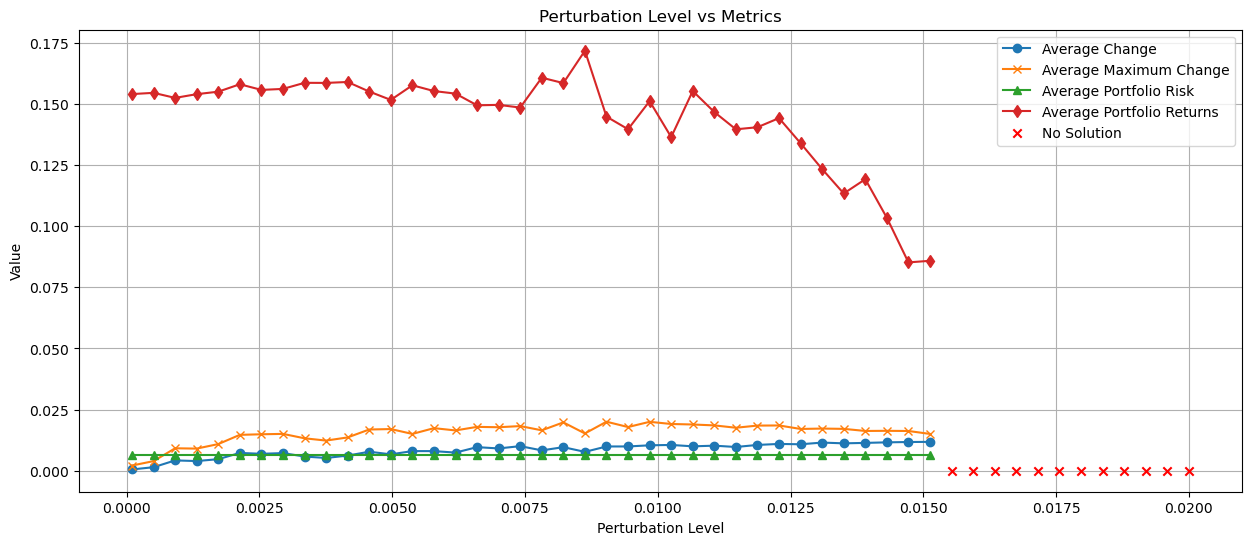

In [8]:
# Plotting the results
plt.figure(figsize=(15, 6))

# Plot each line, skipping NaNs
for column, label, marker in zip(
        ['Average Change', 'Average Maximum Change', 'Average Risk', 'Average Returns'],
        ['Average Change', 'Average Maximum Change', 'Average Portfolio Risk', 'Average Portfolio Returns'],
        ['o', 'x', '^', 'd']):
    
    # Plot the main line (excluding NaNs)
    plt.plot(final_df['Perturbation Level'], final_df[column], label=label, marker=marker, linestyle='-')

# Plot the "No Solution" markers for all columns at once
nan_indices = final_df['Perturbation Level'][final_df.isna().any(axis=1)]
plt.scatter(nan_indices, [0] * len(nan_indices), color='red', marker='x', label='No Solution', zorder=3)

# Set the labels and title
plt.xlabel('Perturbation Level')
plt.ylabel('Value')
plt.title('Perturbation Level vs Metrics')

# Display the legend
plt.legend()
plt.grid(True)
plt.show()


## Stability Across Time Periods

In [9]:
# Define time windows for different periods
time_windows = {
    "Pre-2008 Financial Crisis": ("2005-01-01", "2007-12-31"),
    "Global Financial Crisis": ("2008-01-01", "2009-12-31"),
    "Post-Crisis Recovery": ("2010-01-01", "2015-12-31"),
    "COVID-19 Pandemic": ("2020-01-01", "2021-12-31"),
    "Recent Period": ("2022-01-01", "2024-10-01")
}

In [10]:
# Calculate daily returns and removing first row
daily_returns = data.pct_change().iloc[1:,:]

# Lists to store optimal portfolio weights, returns, risks, and period labels
all_weights = []
optimal_returns = []
optimal_risks = []  # To store the portfolio risks
period_labels = []

# Run the optimization for each time window
for period, (start_date, end_date) in time_windows.items():
    sub_returns = daily_returns.loc[start_date:end_date]

    # Drop columns (assets) that have NaN values for this window
    sub_returns = sub_returns.dropna(axis=1, how='any')

    # If there are fewer than 2 assets left, skip this window
    if len(sub_returns.columns) < 2:
        continue

    sub_cov_matrix = sub_returns.cov() * 252  # Annualized covariance matrix
    sub_expected_returns = sub_returns.mean() * 252  # Annualized expected returns
    
    # Number of assets (after dropping assets with NaN values)
    n_assets = len(sub_expected_returns)

    # Define portfolio weights
    weights = cp.Variable(n_assets)

    # Define portfolio return and risk (variance)
    portfolio_return = sub_expected_returns.values @ weights
    # portfolio_risk = cp.quad_form(weights, cp.psd_wrap(sub_cov_matrix.values))
    portfolio_risk = weights.T @ cp.psd_wrap(sub_cov_matrix.values) @ weights

    # Optimize to maximize return for given risk
    target_risk = 0.08  # Set the target risk directly as the desired standard deviation

    problem = cp.Problem(cp.Maximize(portfolio_return), [
        cp.sum(weights) == 1,  # Sum of weights = 1
        weights >= 0,  # No short selling
        portfolio_risk <= target_risk**2  # Constrain risk to target risk (variance)
    ])
    
    result = problem.solve()
    
    print("Solver used:", problem.solver_stats.solver_name)

    # Ensure the problem was solved successfully
    if problem.status != cp.OPTIMAL:
        print(f"Optimization problem not solved: {problem.status}")
        continue
    
    # Ensure weights.value is a flat array
    optimal_weights = np.array(weights.value).flatten()

    # Store the optimal portfolio weights, returns, and risks for this time window
    all_weights.append(optimal_weights)  # Store the weights array
    optimal_returns.append(portfolio_return.value)  # Store return
    
    # Check if portfolio_risk.value is valid before calculating standard deviation
    if portfolio_risk.value is not None:
        optimal_risks.append(np.sqrt(portfolio_risk.value))  # Store the risk (standard deviation)
    else:
        print("Warning: Portfolio risk is None")
        optimal_risks.append(None)  # Handle None risk values as needed

    # Store the start and end dates of this period for labeling
    period_labels.append(period)

# Convert the list of weights to a DataFrame for better plotting
weights_df = pd.DataFrame(all_weights, columns=tickers, index=period_labels)

# Now you also have the risks and returns for each period
risks_df = pd.DataFrame({
    'Period': period_labels,
    'Return': optimal_returns,
    'Risk': optimal_risks
})

period_labels = weights_df.index.tolist()

# Get a qualitative color scale from Plotly
color_scale = px.colors.qualitative.Plotly

# Dynamically assign colors to tickers (expand the color scale to cover all tickers if necessary)
tickers = weights_df.columns

# Generate a unique color for each ticker using a continuous color scale
color_scale = px.colors.sequential.Inferno  # You can choose another color scale if preferred
color_map = {ticker: px.colors.sample_colorscale(color_scale, i / len(tickers)) for i, ticker in enumerate(tickers)}

# Sort the weights_df for each time period so that larger values are at the bottom
sorted_assets = sorted(weights_df.columns)

# Plot 1: Stacked Bar Plot of Optimal Weights Over Time
fig_weights = go.Figure()

# Add a bar for each asset in the sorted dataframe, adding smaller weights last
for period in period_labels:
    # Sort the assets by weight for this period in descending order
    sorted_weights = weights_df.loc[period].sort_values(ascending=False)
    for asset in sorted_weights.index:
        fig_weights.add_trace(go.Bar(
            x=[period], 
            y=[sorted_weights[asset]], 
            name=asset if period == period_labels[0] else '',  # Show asset name in legend only once
            hovertemplate=asset + '<br>%{y:.2f}',  # Asset name first, then y-axis value
            hoverinfo='y',  # Show only the y value
            showlegend=(period == period_labels[0]),  # Show legend only once
            marker=dict(color=color_map[asset])  # Use dynamically generated unique colors
        ))

# Set plot layout for the stacked bar chart
fig_weights.update_layout(
    barmode='stack',
    title='Optimal Portfolio Weights Over Time',
    xaxis=dict(title='Time Periods', tickangle=45),
    yaxis=dict(title='Weight'),
    legend=dict(title="Assets", yanchor="top", xanchor="left"),
    height=600,
    width=1000
)

# Display the sorted stacked bar chart
fig_weights.show()

# Plot portfolio returns and risks over time (unchanged)
fig_risk_return = go.Figure()

# Add line plot for returns
fig_risk_return.add_trace(go.Scatter(
    x=risks_df['Period'],
    y=risks_df['Return'],
    mode='lines+markers',
    name='Return',
    line=dict(color='blue'),
    hovertemplate='Return: %{y:.2f}<extra></extra>'
))

# Add line plot for risks
fig_risk_return.add_trace(go.Scatter(
    x=risks_df['Period'],
    y=risks_df['Risk'],
    mode='lines+markers',
    name='Risk',
    line=dict(color='red'),
    hovertemplate='Risk: %{y:.2f}<extra></extra>'
))

# Update the layout for the risk-return plot
fig_risk_return.update_layout(
    title='Optimal Portfolio Returns and Risks Over Time',
    xaxis=dict(title='Time Periods', tickangle=45),
    yaxis=dict(title='Value'),
    legend=dict(title="Metrics", yanchor="top", xanchor="left"),
    height=600,
    width=1000
)

# Show the risk-return plot
fig_risk_return.show()

/var/folders/0q/3_k17wq97378_rpc0k5cjj_m0000gn/T/ipykernel_90280/2915363280.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_returns = data.pct_change().iloc[1:,:]


Solver used: ECOS
Solver used: ECOS
Solver used: ECOS
Solver used: ECOS
Solver used: ECOS
